# Convolutional Autoencoders - MNIST dataset


**What if we train the Network with the same input and output?**


**Autoencoders** work this way, compressing the input into a **latent-space** representation, and then reconstructing this representation, providing an output. The **autoencoder** consists of an *encoder* and a *decoder*. The first one reduces the input data from its high dimensionality up to a bottleneck, and the second one recovers the encoded data to take them back to their original form. This bottleneck corresponds to the smallest neural layer. The place where the data is located when it is in this bottleneck layer is known as the **latent space**. Data represented in the **latent space** is very compressed data, such that a well-trained neural network has to be able to transform this simplified representation into the original data.

![CAE](https://cdn-images-1.medium.com/max/2000/1*op0VO_QK4vMtCnXtmigDhA.png)

In this notebook we are going to implement a **Convolutional Autoencoder** to perform various tasks over the **MNIST** dataset: clean the noise in distorted **MNIST** numbers, and visualize an interpolation in the latent space to see the transition between two numbers.



In [0]:
import numpy as np
import scipy as sc
import sklearn as sk
import pandas  as pd
import matplotlib.pyplot as plt

from tensorflow.keras.utils      import to_categorical

# We load the dataset from the file with pandas
mnist = pd.read_csv("./sample_data/mnist_train_small.csv", header=None).as_matrix()  # Save as numpy matrix

# X: sample attributes(20000x784), Y: sample labels (20000x1)
X, Y = mnist[:, 1:], mnist[:, 0:1]

X = X / 255  # Scale the data matrix (20000x744)
Y_cat = to_categorical(Y, 10)  # One-hot encoding: [1,0,0,...,0], [0,1,0,...,0], ..., [0,0,...,0,1]

he, wi = 28, 28  # height and width of an image

X_reshaped = X.reshape((X.shape[0], 28, 28, 1))  # format the images to feed the autoencoder

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped, Y_cat, test_size=0.3)  # Partitioning in training and test data

The architecture of the Convolutional Autoencoder has been determined after an extensive number of tests of different architectures. Finally, an autoencoder with **64 bottleneck neurons** has been used, increasing the number of filters following the powers of 2 from 32 to 256 (and vice versa for decoding). In some of the convolutional layers a **stride** of **2** has been used, as well as **zero padding** (*padding=valid*), with the purpose of not losing information in the reconstruction of the images. Also, Batch Normalization has been applied out of convolutional layer blocks. The structure of the Convolutional Autoencoder has been defined by differentiating the encoder module and the decoder module, since it will be useful when making linear interpolations in the latent space.

To measure the quality of the model, ***Mean Squared Error*** has been used as loss function, and to validate *val_loss* has been employed, since an autoencoder is not a classifier, so it makes no sense to use *accuracy* as metric. In addition, **Stochastic Gradient Descent** has been used as optimizer, as it has experimentally proven to be the most powerful for this dataset, in comparison to the other optimizers.

In [0]:
from tensorflow.python.keras.layers import Conv2D, Conv2DTranspose, Input, Dense, Reshape, Flatten, BatchNormalization
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.optimizers import SGD

  # Encoder     ###############################################################
img = Input(shape=(he, wi, 1), name='image')  # image shape: 28x28x1

x = Conv2D(kernel_size=5, strides=2, filters=32, padding='same', activation='relu', name='con1e')(img)  # 14x14x32

x = Conv2D(kernel_size=5, strides=2, filters=64, padding='same', activation='relu', name='con2e')(x)  # 7x7x64

x = Conv2D(kernel_size=3, strides=1, filters=128, padding='same', activation='relu', name='con3e')(x)  # 7x7x128

x = Conv2D(kernel_size=3, strides=2, filters=256, padding='valid', activation='relu', name='con4e')(x)  # 3x3x256
x = BatchNormalization()(x)

x = Flatten()(x)  # 2304

###############################################################################

enc_img = Dense(64, activation='relu')(x)  # 64, lenght of latent vector

latent = Input(shape=(1, 64), name='latent')

  # Decoder     ###############################################################
x = Dense(2304, activation='relu')(latent)  # 2304

x = Reshape((3, 3, 256))(x)  # 3x3x256
x = BatchNormalization()(x)

x = Conv2DTranspose(kernel_size=3, strides=1, filters=128, padding='same', activation='relu', name='con1d')(x)  # 3x3x128

x = Conv2DTranspose(kernel_size=3, strides=2, filters=64, padding='valid', activation='relu', name='con2d')(x)  # 7x7x64

x = Conv2DTranspose(kernel_size=5, strides=2, filters=32, padding='same', activation='relu', name='con3d')(x)  # 14x14x32

dec_img = Conv2DTranspose(kernel_size=5, strides=2, filters=1, padding='same', activation='sigmoid', name='con4d')(x)  # 28x28x1

###############################################################################

enc = Model(img, enc_img, name='encoder')
dec = Model(latent, dec_img, name='decoder')  # allows to inspect the latent space

img_input = Input(shape=(he, wi, 1), name = 'image_input')
CAE = Model(img_input, dec(enc(img_input)))  # connecting encoder-decoder graphs

checkpoint = ModelCheckpoint(filepath='./weights-CAE.h5', monitor='val_loss', verbose=1, save_best_only='True', save_weights_only='True')

cbks = [EarlyStopping(monitor='loss', patience=10, verbose=1),  # Stop after 10 epochs if val_loss does not improve
        checkpoint]

sgd = SGD(lr=0.015, momentum=0.9, decay=1e-6, nesterov=True)

CAE.compile(optimizer=sgd,
            loss='mse')

In [0]:
CAE_hist = CAE.fit(X_train,
          X_train,
          batch_size=8,
          epochs=60,
          verbose=1,
          validation_data=(X_test, X_test),
          callbacks=cbks)

Train on 14000 samples, validate on 6000 samples
Epoch 1/60
13960/14000 [============================>.] - ETA: 0s - loss: 0.1563
Epoch 00001: val_loss improved from inf to 0.08347, saving model to ./weights-CAE.h5
14000/14000 [==============================] - 20s 1ms/step - loss: 0.1561 - val_loss: 0.0835
Epoch 2/60
13984/14000 [============================>.] - ETA: 0s - loss: 0.0697
Epoch 00002: val_loss improved from 0.08347 to 0.05721, saving model to ./weights-CAE.h5
14000/14000 [==============================] - 17s 1ms/step - loss: 0.0696 - val_loss: 0.0572
Epoch 3/60
13992/14000 [============================>.] - ETA: 0s - loss: 0.0531
Epoch 00003: val_loss improved from 0.05721 to 0.05160, saving model to ./weights-CAE.h5
14000/14000 [==============================] - 17s 1ms/step - loss: 0.0531 - val_loss: 0.0516
Epoch 4/60
13976/14000 [============================>.] - ETA: 0s - loss: 0.0451
Epoch 00004: val_loss improved from 0.05160 to 0.04198, saving model to ./weights-

In [0]:
CAE.load_weights('./weights-CAE.h5')  # Load the model that reached the best val_loss

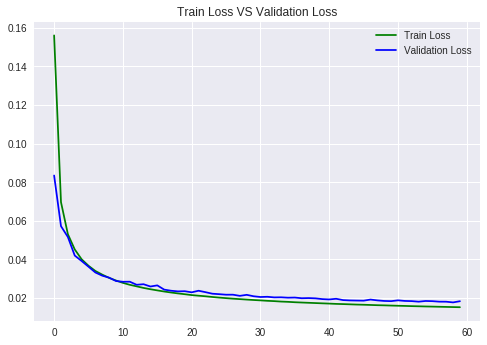

In [0]:
plt.title("Train Loss VS Validation Loss")
plt.plot(CAE_hist.history['loss'],     c='g')
plt.plot(CAE_hist.history['val_loss'], c='b')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

Now, let's try adding noise to the input (we'll use the noise function implemented in the Data Augmentation notebook), and let's check if the model is able to act as a Denoiser Autoencoder:

In [0]:
import random

def noise(X, p):  # Image set noising, with p: percentage of noise
  
  resul = np.zeros(X.shape)
  
  for i, elem in enumerate(X):
    img = elem.reshape(28, 28)
    noise = np.random.uniform(low=-p, high=p, size=(28, 28))  # Create noise mask 28x28 matrix with values in [-p, p)
    resul[i] = np.clip(img + noise, 0.0, 1.0).flatten()  # Sum the noise and, due to data is scaled, clipping between 0 and 1 is needed
    
  return resul

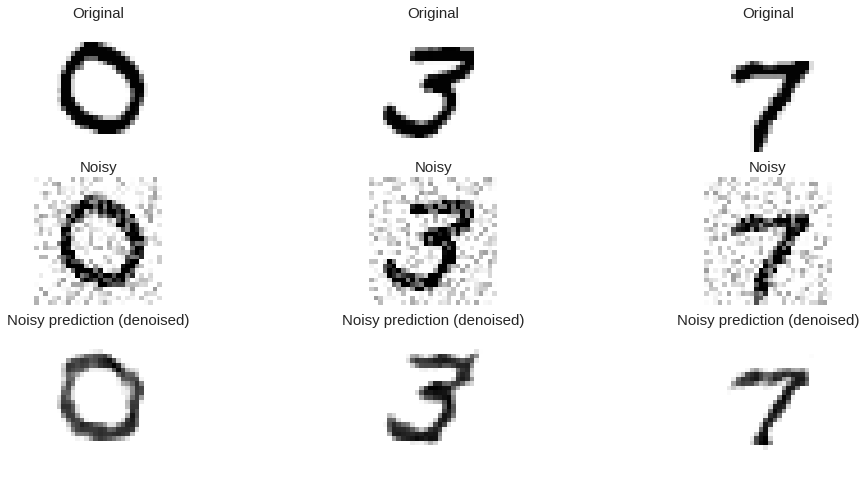

In [0]:
from random import randint

rows = 3
cols = 3  # different MNIST numbers to plot in the comparison

maxval = X.shape[0]
rand1, rand2, rand3 = random.sample(range(0, maxval), cols)

origX = X[[rand1, rand2, rand3],:]  # Select 3 random samples in MNIST
noisX = noise(origX, random.randint(35, 65)/100)  # add noise between (35% and 65%)
predX = CAE.predict(noisX.reshape((noisX.shape[0], 28, 28, 1)))

fig = plt.figure(figsize=(17, 8))

ax = []  # list to manipulate each subplot

  # Simple way to plot each set
for i in range(0,3):  # Plot original numbers
  ax.append(fig.add_subplot(rows, cols, i+1))    
  ax[i].axis('off')
  ax[i].set_title("Original", fontsize=15)
  plt.imshow(origX[i].reshape(28, 28))
  
for i in range(3,6):  # Plot noised numbers
  ax.append(fig.add_subplot(rows, cols, i+1))    
  ax[i].axis('off')
  ax[i].set_title("Noisy", fontsize=15)
  plt.imshow(noisX[i%3].reshape(28, 28))
  
for i in range(6,9):  # Plot denoised numbers
  ax.append(fig.add_subplot(rows, cols, i+1))    
  ax[i].axis('off')
  ax[i].set_title("Noisy prediction (denoised)", fontsize=15)
  plt.imshow(predX[i%6].reshape(28, 28))

plt.show()

As we see in the comparison, the model is able to eliminate almost all the added noise and recover the original image with a high similarity. However, it is very likely that the model is learning the ***identity function*** instead of extracting features. For this reason, and even if the original autoencoder is enough to solve this task, the autoencoder should be **retrained** by providing images with noise as input and the original images as output. We will see this approach in the next notebook, where we will work with color images instead of black and white numbers.



## Linear interpolation in latent space

Now, the latent space will be our playground. We will make a transition between an initial number and a final number, in such a way that we will be able to check how well the latent space understands the structure of the images  [(Julien Despois)](https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df):

![latentspace](https://cdn-images-1.medium.com/max/1000/1*bOdlSOh6MfMJb0s-7oIW9Q.png)

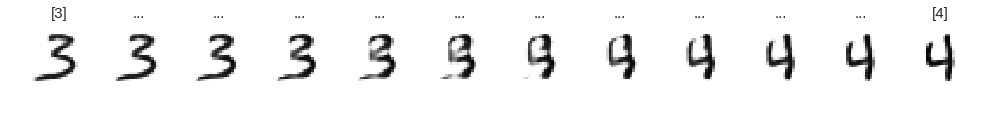

In [0]:
interp_vecs = 12  # Number of interpolations to consider

rnd1 = randint(0, X.shape[0])
rnd2 = randint(0, X.shape[0])

imgs = X[[rnd1, rnd2],:]  # Select 2 random samples (start and end)

  # Feed the encoder with the start-end pair
lv = enc.predict(imgs.reshape((imgs.shape[0], 28, 28, 1)))

fig, ax = plt.subplots(1, interp_vecs, figsize=(17,17))

coeffs = np.linspace(0,1,interp_vecs)

for i, coef in enumerate(coeffs):
  
  # The latent vector is a linear combination between start and end numbers
  vec = lv[0]*(1-coef) + lv[1]*coef
  # Feed the latent vector to the decoder to generate a mixtured reconstruction
  reconstr = dec.predict(vec.reshape(1,1,64))
    
  ax[i].imshow(reconstr.reshape(28, 28))
  ax[i].axis('off')
  ax[i].set_title('...', fontsize=15)

ax[0].set_title(str(Y[rnd1]), fontsize=15)
ax[interp_vecs-1].set_title(str(Y[rnd2]), fontsize=15)

plt.show()

Feeding the encoder with the same start-end pair gives us the possibility to combine their latent vectors linearly. Then, feeding each of the calculated combinations to the decoder, we obtain interesting number reconstructions. Plotting the reconstructions in an orderly fashion we can observe a slow transformation from one to the other, as shown in the figure above.